In [ ]:
!pip install -U yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.49
    Uninstalling yfinance-0.2.49:
      Successfully uninstalled yfinance-0.2.49


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

btc_data = yf.download('BTC-USD', start='2019-01-01', end='2024-11-26')
btc_data = btc_data[['Close']]
btc_data.reset_index(inplace=True)

train_data = btc_data[btc_data['Date'] < '2024-01-01']
test_data = btc_data[btc_data['Date'] >= '2024-01-01']

[*********************100%***********************]  1 of 1 completed


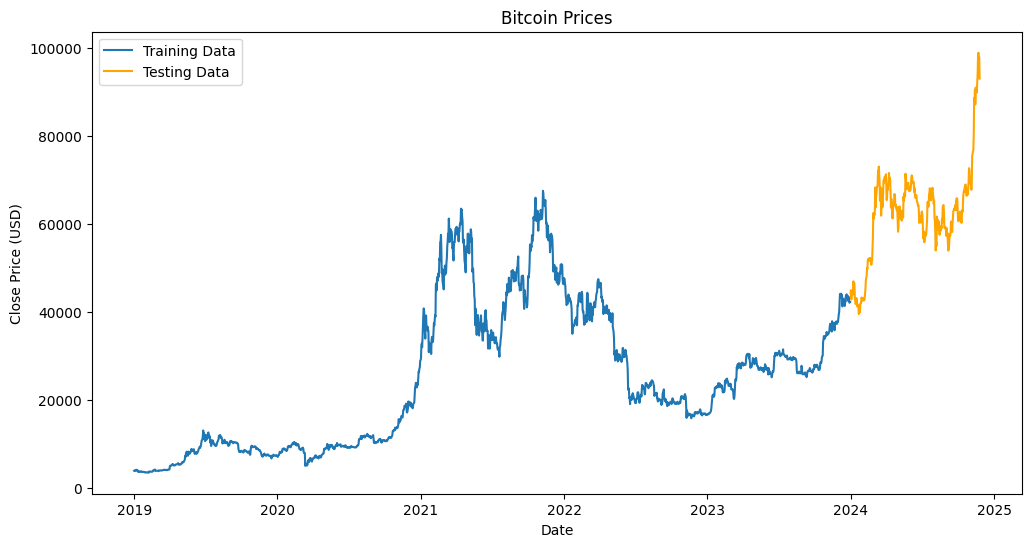

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data')
plt.plot(test_data['Date'], test_data['Close'], label='Testing Data', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Bitcoin Prices')
plt.legend()
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Close']])
test_scaled = scaler.transform(test_data[['Close']])

In [ ]:
SEQ_LEN = 60

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, 0])
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

train_size = int(len(train_scaled) * 0.8)
val_size = len(train_scaled) - train_size

train_data = train_scaled[:train_size]
val_data = train_scaled[train_size:]

X_train, y_train = create_sequences(train_data, SEQ_LEN)

X_val, y_val = create_sequences(val_data, SEQ_LEN)

X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=3, dropout=0.2):
        super(BitcoinLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = BitcoinLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1)

        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.unsqueeze(1)

            preds = model(inputs)
            loss = criterion(preds, labels)

            val_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')


Epoch 1/100, Training Loss: 0.062033885666592556, Validation Loss: 0.03406821694225073
Epoch 2/100, Training Loss: 0.008033252178310331, Validation Loss: 0.0008589447912527248
Epoch 3/100, Training Loss: 0.0034508985911749983, Validation Loss: 0.0008102054220216814
Epoch 4/100, Training Loss: 0.0027775732662782752, Validation Loss: 0.000641531227302039
Epoch 5/100, Training Loss: 0.0024649334108372304, Validation Loss: 0.0006028563497238792
Epoch 6/100, Training Loss: 0.002279789487312717, Validation Loss: 0.0005994612103677355
Epoch 7/100, Training Loss: 0.0021712562183066357, Validation Loss: 0.0007193225119408453
Epoch 8/100, Training Loss: 0.0021648486898894507, Validation Loss: 0.0005070677740150132
Epoch 9/100, Training Loss: 0.0018729850159037267, Validation Loss: 0.0013866620021872223
Epoch 10/100, Training Loss: 0.0017739752259909767, Validation Loss: 0.0004936040946631693
Epoch 11/100, Training Loss: 0.001784225370184603, Validation Loss: 0.0007943640397570561
Epoch 12/100, T

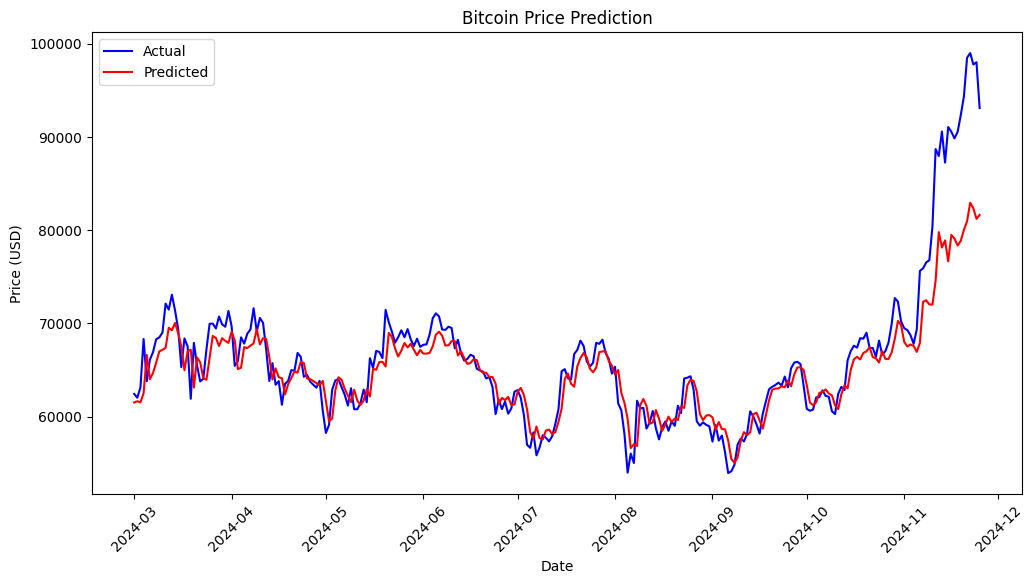

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze().numpy()

y_test_actual = scaler.inverse_transform(y_test.unsqueeze(1))
predictions_actual = scaler.inverse_transform(predictions.reshape(-1, 1))

test_dates = btc_data['Date'][-len(test_scaled) + SEQ_LEN:]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual', color='blue')
plt.plot(test_dates, predictions_actual, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.show()
